# The whole-body 3D reconstruction

This notebook demonstrates the process of whole-body 3D reconstruction based on 3D spatial transcriptome data. This is done in the following four steps.

1. Construct the original 3D point cloud model;
2. Construct the whole body mesh model based on the 3D point cloud model;
3. Construct the voxel model based on the mesh model;
4. Save the models.

This example reconstructs 3D Drosophila embryos model based on 3D spatial transcriptome data of Drosophila embryos.

### Packages

In [40]:
import os
import numpy as np
import spateo as st

### Data source

In [5]:
adata = st.read_h5ad("/media/yao/Yao/Projects/Project_spateo/Data/E8-10_b_sample/5_annotation/cluster_res2.2/E8-10_b_cellbin.h5ad")
print(adata)

save_folder = "/media/yao/Yao/Projects/Project_spateo/Data/E8-10_b_sample/6_three_dims_reconstruction"
save_tdr_folder = os.path.join(save_folder, f"E8-10_b_spateo")
save_model_folder = os.path.join(save_tdr_folder, f"wb_model")
save_image_folder = os.path.join(save_tdr_folder, f"wb_image")

for folder in [save_folder, save_tdr_folder, save_image_folder, save_model_folder]:
    if not os.path.exists(folder):
        os.mkdir(folder)

AnnData object with n_obs × n_vars = 11276 × 8752
    obs: 'area', 'slices', 'x', 'y', 'z', 'nGenes', 'nCounts', 'pMito', 'nMito', 'pass_basic_filter', 'scc', 'anno_tissue', 'anno_cell'
    var: 'nCells-E8-10_b_S06', 'nCounts-E8-10_b_S06', 'pass_basic_filter-E8-10_b_S06', 'nCells-E8-10_b_S07', 'nCounts-E8-10_b_S07', 'pass_basic_filter-E8-10_b_S07', 'nCells-E8-10_b_S08', 'nCounts-E8-10_b_S08', 'pass_basic_filter-E8-10_b_S08', 'nCells-E8-10_b_S09', 'nCounts-E8-10_b_S09', 'pass_basic_filter-E8-10_b_S09', 'nCells-E8-10_b_S10', 'nCounts-E8-10_b_S10', 'pass_basic_filter-E8-10_b_S10', 'nCells-E8-10_b_S11', 'nCounts-E8-10_b_S11', 'pass_basic_filter-E8-10_b_S11', 'nCells-E8-10_b_S12', 'nCounts-E8-10_b_S12', 'pass_basic_filter-E8-10_b_S12', 'nCells-E8-10_b_S13', 'nCounts-E8-10_b_S13', 'pass_basic_filter-E8-10_b_S13', 'nCells-E8-10_b_S14', 'nCounts-E8-10_b_S14', 'pass_basic_filter-E8-10_b_S14', 'nCells-E8-10_b_S15', 'nCounts-E8-10_b_S15', 'pass_basic_filter-E8-10_b_S15', 'nCells-E8-10_b_S16', 'nC

### Construct the original 3D point cloud model

#### Construct point cloud model

In [6]:
tissue_colormap = {
    "CNS": "#5A2686",
    "Sensory nervous system": "#C9CBFF",
    "Tracheal": "#7F90F0",
    "Midgut": "#DC143C",
    "Foregut": "#003FFF",
    "Fat body": "#92a900",
    "Epidermis": "#ADD8E6",
    "Muscle": "#1AAB27",
    "Amnioserosa": "#FFDD00",
    "Salivary gland body": "#FFA500",
    "Plasmatocytes": "#8B0000",
    "Procrystal cell": "#CD5C5C",
    "Head ectoderm": "#F8A76F",
}

rpc = st.tdr.construct_pc(adata=adata, spatial_key="tdr_spatial", groupby="anno_tissue", key_added="tissue", colormap=tissue_colormap)

#### Add any other labels you want to the point cloud model

In [7]:
st.tdr.add_model_labels(model=rpc, key_added="cell_area", labels=adata.obs["area"].values.flatten(), colormap="hot_r", where="point_data", inplace=True)

#### Adjust the original point cloud model

##### Crop the point cloud model

In [8]:
apc = st.tdr.interactive_rectangle_clip(model=rpc, key="tissue", invert=True)[0]

##### Rotate the point cloud model

In [9]:
st.tdr.rotate_model(model=apc, angle=(0, 0, 180), inplace=True)

#### Visualize point cloud model

##### Save the figure

In [ ]:
st.pl.three_d_plot(model=apc, key="tissue", model_style="points", model_size=5, window_size=(512, 512), off_screen=True,
                   filename=os.path.join(save_image_folder, "wb_pc_iso.pdf"))

In [39]:
st.pl.three_d_multi_plot(model=apc, key="tissue", model_style="points", model_size=5, shape=(2, 3), off_screen=True, cpo=["xy", "xz", "yz", "yx", "zx", "zy"],
                         text=["cpo: xy", "cpo: xz", "cpo: yz", "cpo: yx", "cpo: zx", "cpo: zy"], text_kwargs={"text_size": 10},
                         show_legend=True, legend_kwargs={"legend_size":(0.2, 0.17)}, filename=os.path.join(save_image_folder, "wb_pc_six.pdf"))

##### show in jupyter

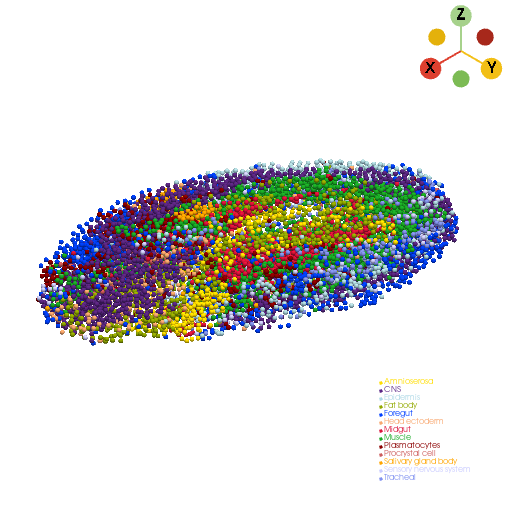

In [25]:
st.pl.three_d_plot(model=apc, key="tissue", model_style="points", model_size=5, window_size=(512, 512), jupyter="static", filename=None)

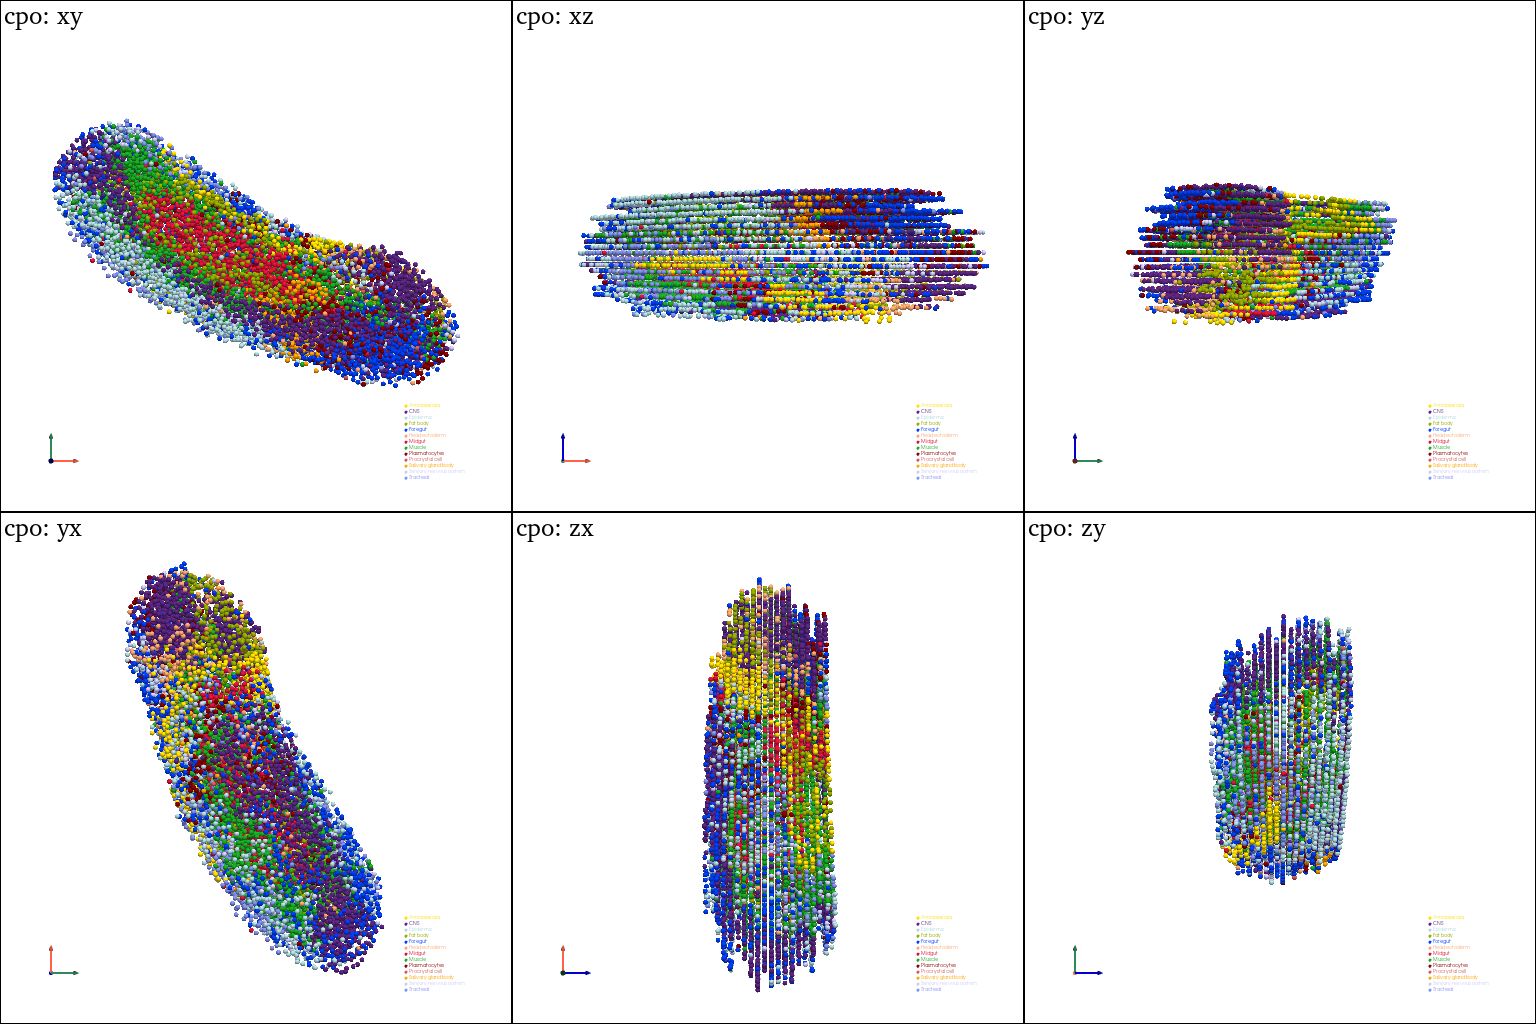

In [38]:
st.pl.three_d_multi_plot(model=apc, key="tissue", model_style="points", shape=(2, 3), cpo=["xy", "xz", "yz", "yx", "zx", "zy"],
                         text=["cpo: xy", "cpo: xz", "cpo: yz", "cpo: yx", "cpo: zx", "cpo: zy"], text_kwargs={"text_size": 10},
                         show_legend=True, legend_kwargs={"legend_size":(0.2, 0.17)}, model_size=5, jupyter="static", filename=None)

### Construct the whole body mesh model based on the 3D point cloud model

#### Construct shell mesh model

In [13]:
shell, pc = st.tdr.construct_surface(pc=apc, key_added="tissue", label="whole_body", color="gainsboro", alpha=0.6, uniform_pc=True,
                                     cs_method="marching_cube", smooth=3000, scale_factor=1.03)

#### Construct cells mesh model

In [14]:
cell_radius = pow(np.asarray(pc.point_data["cell_area"]), 1/2)
cell_mesh = st.tdr.construct_cells(pc=pc, cell_size=cell_radius, geometry="sphere", factor=0.3)

#### Merge shell mesh and point cloud

In [15]:
sp_model = st.tdr.collect_model(models=[shell, pc])

#### Merge shell mesh and cell mesh

In [16]:
# st.tdr.add_model_labels(model=shell, key_added="tissue", labels=np.asarray(["whole_body"] * shell.n_points), colormap="gainsboro", where="point_data", inplace=True)
sc_model = st.tdr.collect_model(models=[shell, cell_mesh])

#### Visualize mesh model

##### Visualize shell model

In [17]:
st.pl.three_d_plot(model=shell, key="tissue", model_style="surface", window_size=(512, 512), off_screen=True,
                   filename=os.path.join(save_image_folder, "wb_shell_iso.pdf"))

In [18]:
st.pl.three_d_multi_plot(model=shell, key="tissue", model_style="surface", shape=(2, 3), off_screen=True, cpo=["xy", "xz", "yz", "yx", "zx", "zy"],
                         text=["cpo: xy", "cpo: xz", "cpo: yz", "cpo: yx", "cpo: zx", "cpo: zy"], text_kwargs={"text_size": 10},
                         show_legend=True, filename=os.path.join(save_image_folder, "wb_shell_six.pdf"))

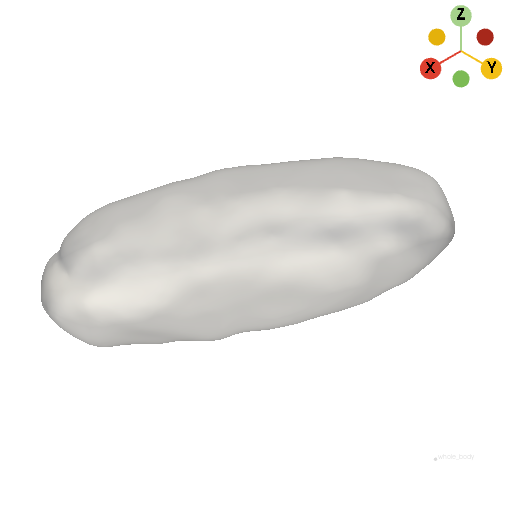

In [19]:
st.pl.three_d_plot(model=shell, key="tissue", model_style="surface", window_size=(512, 512), off_screen=True, jupyter="static", filename=None)

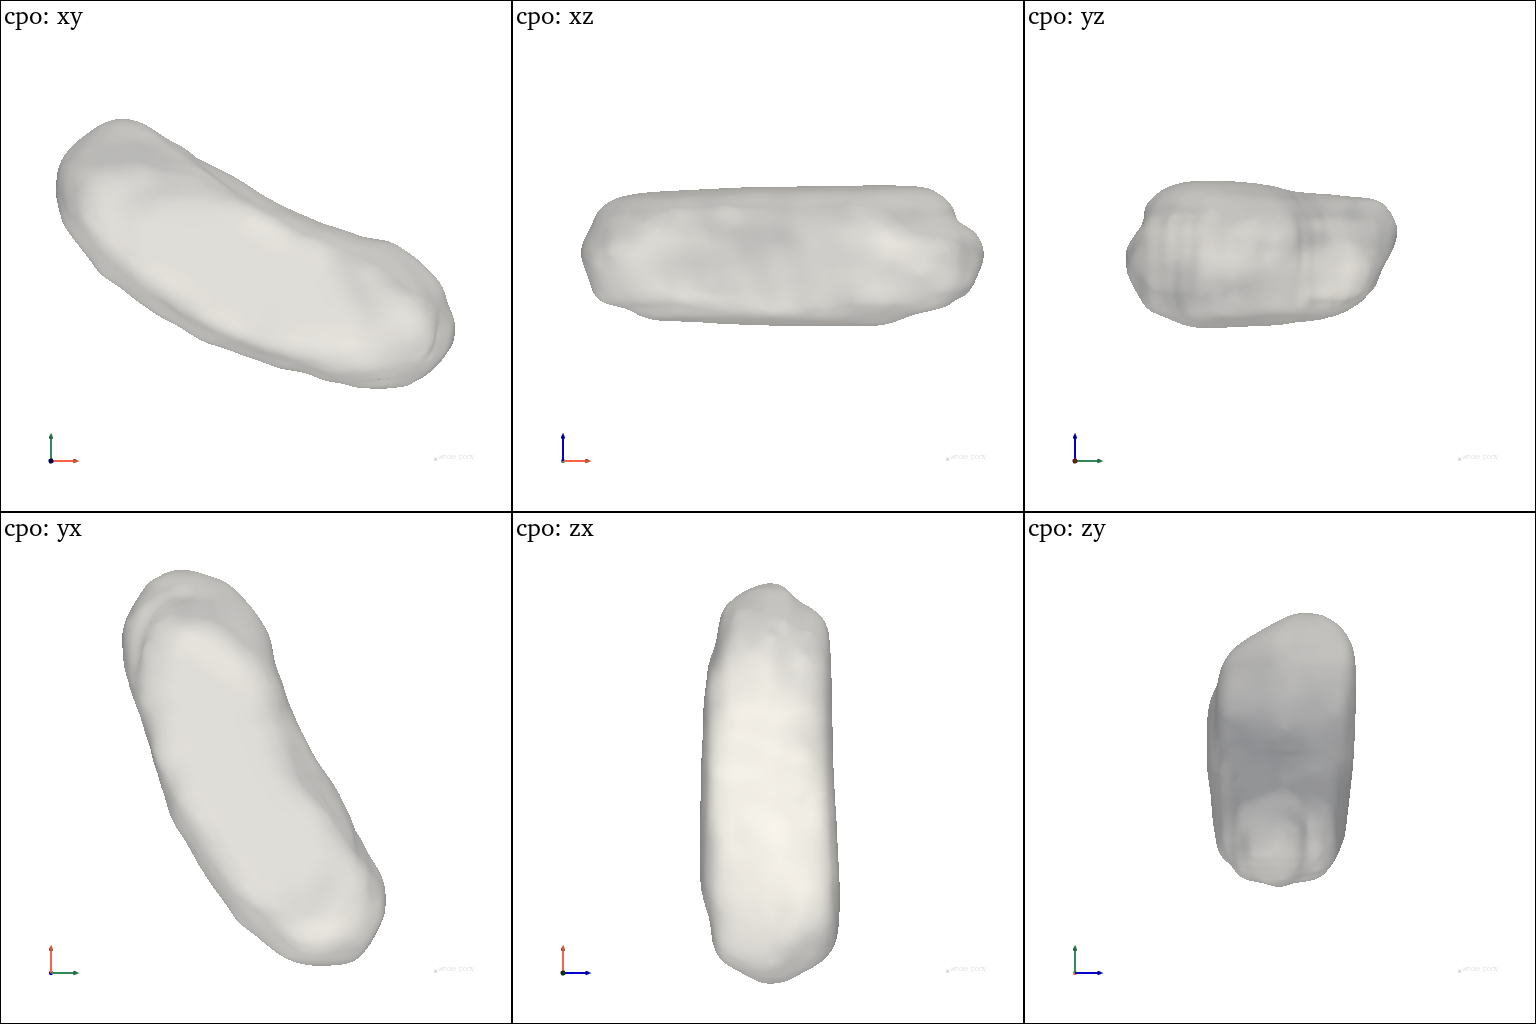

In [20]:
st.pl.three_d_multi_plot(model=shell, key="tissue", model_style="surface", shape=(2, 3), off_screen=True, cpo=["xy", "xz", "yz", "yx", "zx", "zy"],
                         text=["cpo: xy", "cpo: xz", "cpo: yz", "cpo: yx", "cpo: zx", "cpo: zy"], text_kwargs={"text_size": 10},
                         show_legend=True, jupyter="static", filename=None)

##### Visualize shell mesh and point cloud

In [21]:
st.pl.three_d_plot(model=sp_model, key="tissue", model_style=["surface", "points"], model_size=5, window_size=(512, 512), off_screen=True,
                   filename=os.path.join(save_image_folder, "wb_sp_iso.pdf"))

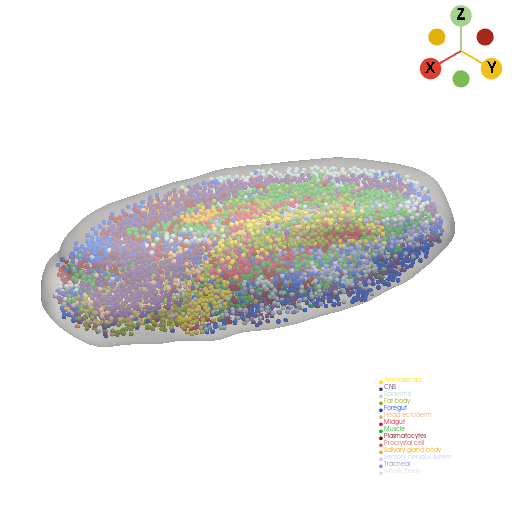

In [22]:
st.pl.three_d_plot(model=sp_model, key="tissue", model_style=["surface", "points"], model_size=5, window_size=(512, 512), off_screen=True,
                   jupyter="static", filename=None)

##### Visualize shell mesh and cell mesh

In [23]:
st.pl.three_d_plot(model=sc_model, key="tissue", model_style="surface", window_size=(512, 512), off_screen=True,
                   filename=os.path.join(save_image_folder, "wb_sc_iso.pdf"))

In [24]:
sc_model_multi = st.tdr.collect_model([sc_model])
st.pl.three_d_multi_plot(model=sc_model_multi, key="tissue", model_style="surface", shape=(2, 3), off_screen=True, cpo=["xy", "xz", "yz", "yx", "zx", "zy"],
                         text=["cpo: xy", "cpo: xz", "cpo: yz", "cpo: yx", "cpo: zx", "cpo: zy"], text_kwargs={"text_size": 10},
                         show_legend=True, legend_kwargs={"legend_size":(0.2, 0.17)}, filename=os.path.join(save_image_folder, "wb_sc_six.pdf"))

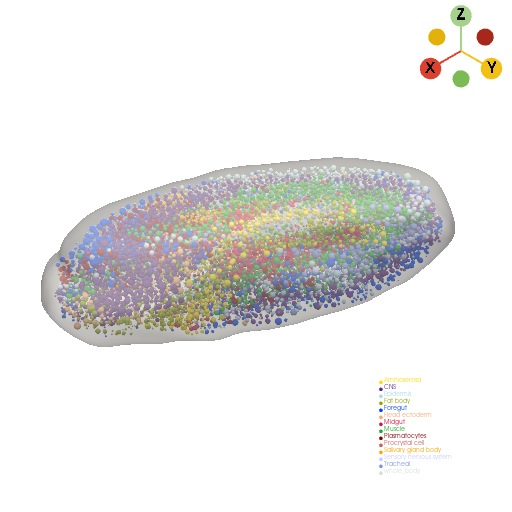

In [25]:
st.pl.three_d_plot(model=sc_model, key="tissue", model_style="surface", window_size=(512, 512), off_screen=True, jupyter="static", filename=None)

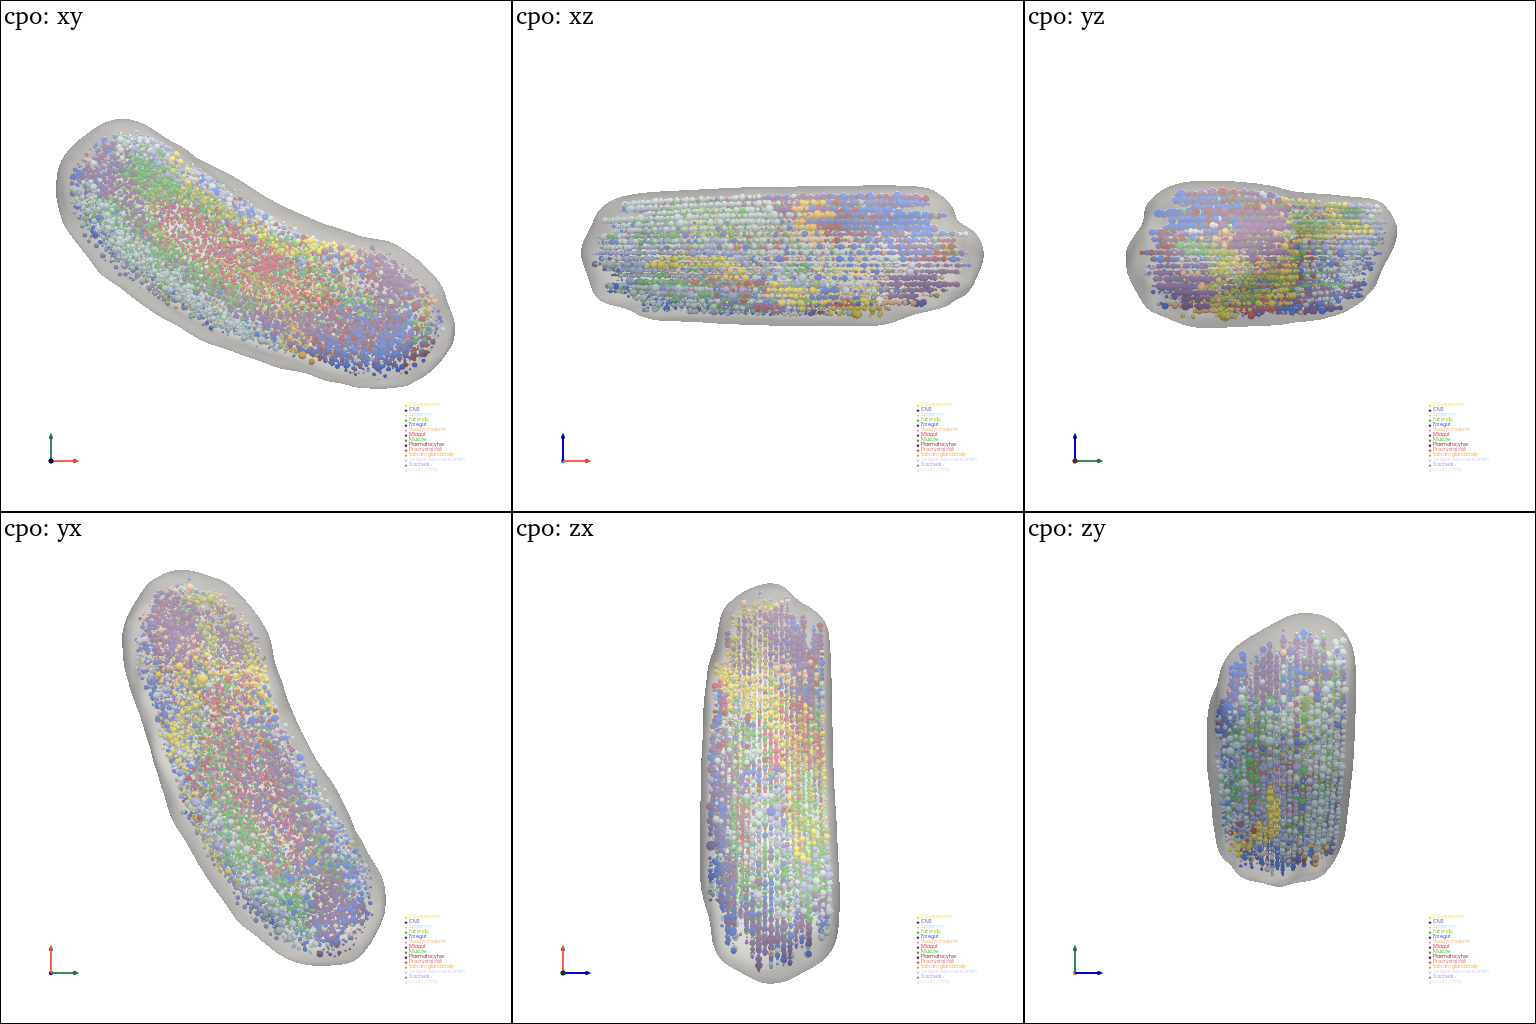

In [26]:
st.pl.three_d_multi_plot(model=sc_model_multi, key="tissue", model_style="surface", shape=(2, 3), off_screen=True, cpo=["xy", "xz", "yz", "yx", "zx", "zy"],
                         text=["cpo: xy", "cpo: xz", "cpo: yz", "cpo: yx", "cpo: zx", "cpo: zy"], text_kwargs={"text_size": 10},
                         show_legend=True, legend_kwargs={"legend_size":(0.2, 0.17)}, jupyter="static", filename=None)

### Construct the whole body voxel model based on the mesh model

#### Construct shell voxel model

In [27]:
svoxel = st.tdr.voxelize_mesh(mesh=shell, voxel_pc=None, key_added="tissue", label="whole_body", color="gainsboro", smooth=500)

#### Visualize voxel model

##### Visualize shell voxel model

In [28]:
st.pl.three_d_plot(model=svoxel, key="tissue", model_style="surface", window_size=(512, 512), off_screen=True,
                   filename=os.path.join(save_image_folder, "wb_voxel_iso.pdf"))

In [29]:
st.pl.three_d_multi_plot(model=svoxel, key="tissue", model_style="surface", shape=(2, 3), off_screen=True,
                         cpo=["xy", "xz", "yz", "yx", "zx", "zy"],
                         text=["cpo: xy", "cpo: xz", "cpo: yz", "cpo: yx", "cpo: zx", "cpo: zy"],
                         text_kwargs={"text_size": 10},
                         show_legend=True, filename=os.path.join(save_image_folder, "wb_voxel_six.pdf"))

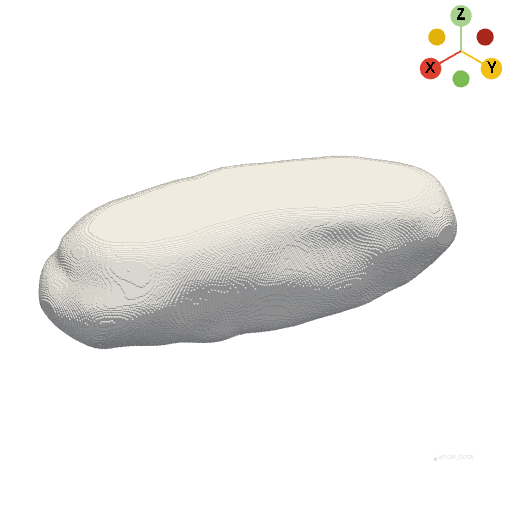

In [30]:
st.pl.three_d_plot(model=svoxel, key="tissue", model_style="surface", window_size=(512, 512), off_screen=True,
                   jupyter="static", filename=None)

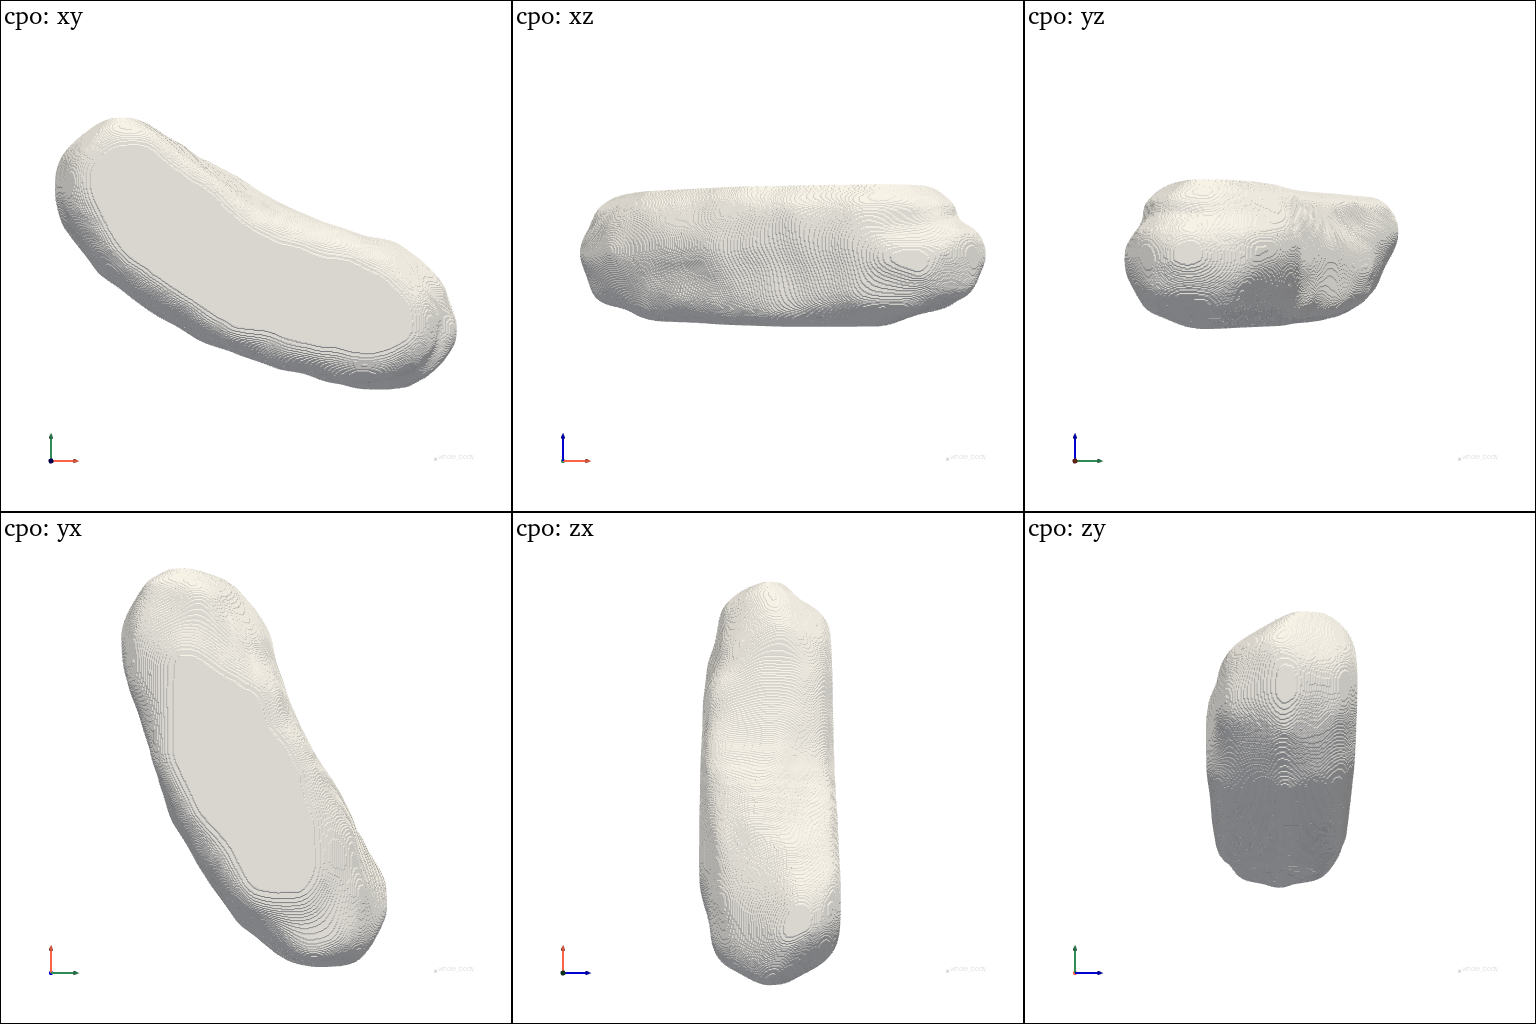

In [31]:
st.pl.three_d_multi_plot(model=svoxel, key="tissue", model_style="surface", shape=(2, 3), off_screen=True, cpo=["xy", "xz", "yz", "yx", "zx", "zy"],
                         text=["cpo: xy", "cpo: xz", "cpo: yz", "cpo: yx", "cpo: zx", "cpo: zy"], text_kwargs={"text_size": 10},
                         show_legend=True, jupyter="static", filename=None)

### Save models

In [32]:
st.tdr.save_model(model=pc, filename=os.path.join(save_model_folder, "wb_pc.vtk"))
st.tdr.save_model(model=shell, filename=os.path.join(save_model_folder, "wb_shell_mesh.vtk"))
st.tdr.save_model(model=cell_mesh, filename=os.path.join(save_model_folder, "wb_cell_mesh.vtk"))
st.tdr.save_model(model=svoxel, filename=os.path.join(save_model_folder, "wb_voxel.vtk"))